### Задание

Ознакомиться со структурой датасета, в котором хранятся сведения о результатах сходов/крушений подвижного состава вне стрелочных переводов по причине неисправности подвижного состава.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

df = pd.read_excel("WO.xlsx")
df.head()

,date,length,commonlength,maxder,dcar,speed,weight,load,curve,profile,type
0,2013-01-03,68,70,61,1,6,4875,0.705669,0.005000,0.0000,2
1,2013-01-03,43,45,2,1,30,3955,0.999663,0.005000,NaN,2
2,2013-01-10,70,72,65,4,10,1658,0.009938,NaN,NaN,2
3,2013-01-10,56,58,44,10,29,2651,0.352743,0.003333,-0.0164,2
4,2013-01-12,68,71,23,1,5,2522,0.204177,0.003333,NaN,2


`length` – количество вагонов в поезде;

`commonlength` – количество вагонов и секций локомотива в поезде;

`maxder` – количество вагонов и секций локомотива в поезде минус номер первой сошедшей с рельсов подвижной единицы (от головы поезда) + 1;

`dcar` – количество вагонов и секций локомотива в сходе;

`speed` – скорость поезда в месте схода, км/ч;

`weight` – вес поезда, т.;

`load` – показатель, характеризующий степень загруженности поезда полезной нагрузкой, чем меньше порожних вагонов, тем больше этот показатель;

`curve` – кривизна пути в месте схода;

`profile` – величина профиля пути в месте схода в тысячных.

Загрузить указанный датасет в любой математический пакет по выбору студента.

Построить различные зависимости вида $dcar=f(length, \dots,profile)$ на основе метода наименьших квадратов, полагая, что

$$ dcar_k = f(length_k, \dots, profile_k)+\varepsilon_k, $$
где $k=1, \dots, n, n$ - количество наблюдений, $\varepsilon_1, \dots, \varepsilon_n$ - независимые одинаково распределенные ошибки.

Построить не менее 10 таких зависимостей. Проводить построение зависимостей на выборках с вычеркиванием строк, в которых имеется хотя бы одно пропущенное наблюдение чего-либо; а также необходимо проводить построение зависимостей с вычеркиванием только тех строк, в которых пропущено необходимое для построения зависимости наблюдение.

Для каждой построенной зависимости привести значения скорректированного коэффициента детерминации, средней абсолютной погрешности, средней относительной погрешности, оценку дисперсии ошибок.

Определить наилучшую из построенных зависимостей и объяснить, почему она, на взгляд студента, является наилучшей.

Определив вид наилучшей зависимости, разбить выборку на две части в пропорции: 70 на 30. Выбор разбиения предоставляется студенту: например, можно выбрать эти 70 процентов наблюдений случайным образом, можно же взять первые 70 процентов наблюдений по порядку их нахождения в датасете. На 70 процентах наблюдений провести обучение модели (то есть подбор неизвестных коэффициентов). На этих 70 процентах наблюдений вычислить значения
- скорректированного коэффициента детерминации;
- средней абсолютной погрешности;
- средней относительной погрешности;
- оценки дисперсии ошибок.

А также для полученной модели на 30 процентах наблюдений, на которых модель не обучалась, привести значения
- скорректированного коэффициента детерминации;
- средней абсолютной погрешности;
- средней относительной погрешности;
- оценки дисперсии ошибок.

Сделать вывод из полученных результатов.

### Решение

Посчитаем коэффициенты корреляции между всеми столбцаи исходных данных, отобразим это на рисунке.

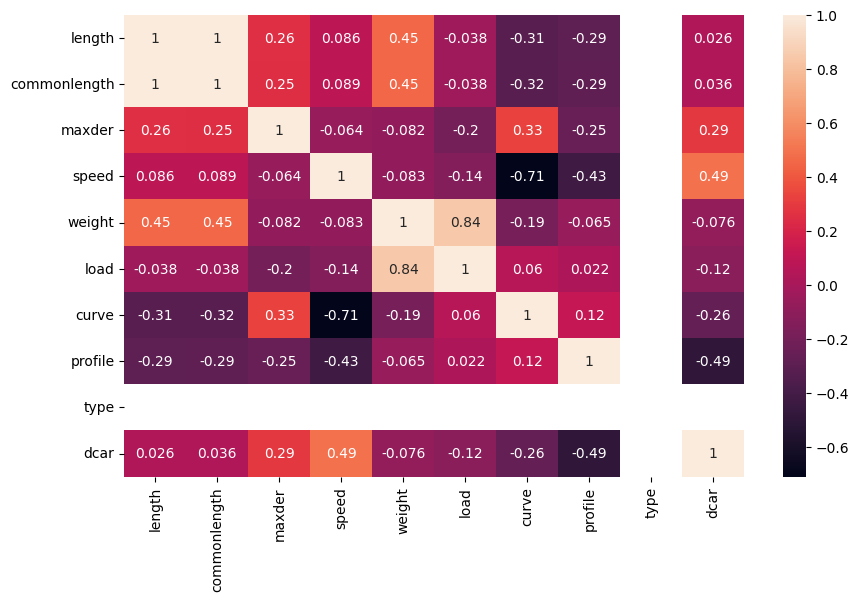

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
corr = df[['length', 'commonlength', 'maxder', 'speed', 'weight',
       'load', 'curve', 'profile', 'type', 'dcar']].corr()
sns.heatmap(corr, annot=True, ax=ax)
plt.show()

Напишем метод, который будет применять метод линейной регрессии `LinearRegression` из библиотеки `sklearn.linear_model`. Это и есть метод наименьших квадратов, который заключается минимизации функции:

$$ F(\beta) = \sum\limits_{k=1}^n(y_k-f(x, \beta))^2 \rightarrow \min_{\beta}, $$
где $y_k, k=1,\dots,n$ - набор скалярных экспериментальных данных, интересующий нас столбец таблицы `dcar`, $x_k$ - набор векторных экспериментальных данных и предполагается, что $y$ зависит от $x$. $f(x, \beta)$ - скалярная функция, которая определяется вектором неизвестных параметров $\beta$.

Коэффиент детерминации ($R^2$), скорректированный коэффициент детерминации ($R_{adj}^2$), оценка дисперсии ошибок ($\hat{D}[\varepsilon_n]$) средняя абсолютная ($\Delta$) и относительная ($\delta$) погрешности рассчитываются согласно формулам:

$$ R^2 = 1 - \frac{\sum\limits_{k=1}^n\left( y_k - f(x, \beta) \right)^2}{\sum\limits_{k=1}^n\left( y_k - \overline{y}_n \right)^2}, $$

$$ R_{adj}^2 = 1 + \frac{n-1}{n-p} (R^2-1), $$

$$ \hat{D}[\varepsilon_n] = \frac{\sum\limits_{k=1}^n\left( y_k - f(x, \beta) \right)^2}{n-p}, $$

$$ \Delta = \frac{1}{n}\sum\limits_{k=1}^n \left| y_k - f(x, \beta) \right|, $$

$$ \delta = \frac{1}{n}\sum\limits_{k=1}^n \frac{\left| y_k - f(x, \beta) \right|}{y_k}, $$
здесь $n$ - количество наблюдеений, $p$ - количество столбцов, используемых для построения функции $f(x, \beta)$

In [3]:
def solve(df):
    y = df['dcar']
    X = df.drop(['dcar'], axis=1)
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    n = X.shape[0]
    p = X.shape[1]

    y_np = y.to_numpy()
    r2 = 1 - sum([(y_np[i] - y_pred[i])**2 for i in range(len(y_np))])/sum([(y_np[i] - np.mean(y_np))**2 for i in range(len(y))])
    adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
    mae = mean_absolute_error(y, y_pred)
    mre = np.mean([abs((true - pred)/true) if true != 0 else 0 
                for true, pred in zip(y, y_pred)])
    error_variance = np.var(y - y_pred, ddof=p+1)
    
    return {
        'names': model.feature_names_in_,
        'intercept': model.intercept_,
        'params': model.coef_,
        'y': y.to_numpy(),
        'y_pred': y_pred,
        'r2': r2,
        'adj_r2': adj_r2,
        'mae': mae,
        'mre': mre,
        'error_variance': error_variance
    }

In [5]:
def predict_dcar(df):
    X = df.drop('dcar', axis=1)
    y = df['dcar']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    n_train = X_train.shape[0]
    p_train = X_train.shape[1]

    r2_train = model.score(X_train, y_train)
    adj_r2_train = 1 - (1-r2_train)*(n_train-1)/(n_train-p_train-1)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mre_train = np.mean([abs((true - pred)/true) if true != 0 else 0 
                for true, pred in zip(y_train, y_train_pred)])
    error_variance_train = np.var(y_train - y_train_pred, ddof=p_train+1)

    y_test_pred = model.predict(X_test)

    n_test = X_test.shape[0]
    p_test = X_test.shape[1]
    r2_test = model.score(X_test, y_test)
    adj_r2_test = 1 - (1-r2_test)*(n_test-1)/(n_test-p_test-1)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mre_test = np.mean([abs((true - pred)/true) if true != 0 else 0 
                for true, pred in zip(y_test, y_test_pred)])
    error_variance_test = np.var(y_test - y_test_pred, ddof=p_test+1)
    
    return {
        'params': model.coef_,
        'y_train': y_train.to_numpy(),
        'y_train_pred': y_train_pred,
        'y_test': y_test.to_numpy(),
        'y_test_pred': y_test_pred,
        'r2_train': r2_train,
        'adj_r2_train': adj_r2_train,
        'mae_train': mae_train,
        'mre_train': mre_train,
        'error_variance_train': error_variance_train,
        'r2_test': r2_test,
        'adj_r2_test': adj_r2_test,
        'mae_test': mae_test,
        'mre_test': mre_test,
        'error_variance_test': error_variance_test
    }

Пострим зависимость столбца `dcar` от всех остальных, за исключением столбца `load`. Если в строке имеется хотя бы одно пропущенное значение, строка исключается.

In [6]:
# Тест 1
dd = df[['length', 'commonlength', 'maxder', 'speed', 'weight', 'curve', 'profile', 'dcar']].copy().dropna()
res_1 = solve(dd)
ans_1 = "dcar = "
for i in range(len(res_1['params'])):
    ans_1 += f"{res_1['params'][i]:.4f}*{res_1['names'][i]} + "
ans_1 += str(format(res_1['intercept'], '.4f'))
print(ans_1)
res_1

dcar = 4.3031*length + -4.4941*commonlength + -0.0673*maxder + 0.2141*speed + 0.0008*weight + 291.1357*curve + -187.2305*profile + 20.1357


{'names': array(['length', 'commonlength', 'maxder', 'speed', 'weight', 'curve',
        'profile'], dtype=object),
 'intercept': 20.135736720944596,
 'params': array([ 4.30310462e+00, -4.49410971e+00, -6.72521442e-02,  2.14147133e-01,
         8.35307425e-04,  2.91135743e+02, -1.87230524e+02]),
 'y': array([ 1, 10,  3,  4,  1,  1,  4,  1,  2], dtype=int64),
 'y_pred': array([0.86947568, 9.9578379 , 2.91853155, 3.88127233, 0.98935559,
        1.16251404, 4.25410217, 0.96268808, 2.00422266]),
 'r2': 0.9980580933742826,
 'adj_r2': 0.9844647469942611,
 'mae': 0.09351974999115183,
 'mre': 0.05196509381810041,
 'error_variance': 0.132049650548782}

Можем заметить, что функция хорошо приблизила значения исходного столбца `dcar`, однако в датасете осталось всего 9 наблюдений. Было бы ошибочно считать результаты на столь маленькой выборке статистически значимыми. Поэтому в дальнейшем не будем рассматривать столбцы с большим количеством пропусков, а именно `curve` и `profile`. 

Разберем различные варианты набора столбцов $x$.

In [7]:
# Тест 2
dd = df[['length', 'commonlength', 'maxder', 'speed', 'weight', 'load', 'dcar']].copy().dropna()
res_2 = solve(dd)
ans_2 = "dcar = "
for i in range(len(res_2['params'])):
    ans_2 += f"{res_2['params'][i]:.4f}*{res_2['names'][i]} + "
ans_2 += str(format(res_2['intercept'], '.4f'))
print(ans_2)
res_2

dcar = -1.3116*length + 1.2291*commonlength + 0.0668*maxder + 0.1138*speed + 0.0011*weight + -4.3757*load + -1.1437


{'names': array(['length', 'commonlength', 'maxder', 'speed', 'weight', 'load'],
       dtype=object),
 'intercept': -1.143744969037583,
 'params': array([-1.31159228e+00,  1.22909740e+00,  6.68333025e-02,  1.13811243e-01,
         1.05200087e-03, -4.37565339e+00]),
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([ 2.5052377 ,  1.10165903,  2.72281852,  4.18130033,  0.79985506,
         4.61547155,  6.96470361, -0.38404722,  4.55563641,  4.88080037,
        -1.86446744,  3.08598011,  5.89425355,  1.83370344, -0.29417838,
         2.09637418,  1.71967258,  6.39362387,  3.00977436,  2.87082375,
        12.61074943,  3.89256418,  2.4992724 ,  5.66870806,  3.71235663,
         3.68902635,  0.30741042,  3.97759625,  2.11815329,  2.47997021,
         3.04052329,  3.57353692,  2.56955085,  4.83249732,  6.5394403 ,
        

In [8]:
# Тест 3
dd = df[['length', 'maxder', 'speed', 'weight', 'load', 'dcar']].copy().dropna()
res_3 = solve(dd)
ans_3 = "dcar = "
for i in range(len(res_3['params'])):
    ans_3 += f"{res_3['params'][i]:.4f}*{res_3['names'][i]} + "
ans_3 += str(format(res_3['intercept'], '.4f'))
print(ans_3)
res_3

dcar = -0.0853*length + 0.0584*maxder + 0.1162*speed + 0.0012*weight + -5.0364*load + 2.4019


{'names': array(['length', 'maxder', 'speed', 'weight', 'load'], dtype=object),
 'intercept': 2.401863433914237,
 'params': array([-8.53295607e-02,  5.83519050e-02,  1.16191132e-01,  1.18874852e-03,
        -5.03637231e+00]),
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([ 3.09720238,  2.00195564,  3.30447347,  4.93526056,  0.49221352,
         5.22682108,  8.00058377,  0.6284258 ,  2.9513824 ,  5.20016848,
        -0.75440279,  3.84608914,  7.06296635,  2.76963315,  0.59951396,
         2.718737  ,  0.39464326,  4.76939823,  1.44159386,  3.49451044,
        10.80067049,  3.92343801,  3.3067566 ,  5.02753669,  2.18738308,
         4.53922161, -0.0198674 ,  4.59872534,  2.21862295,  1.99898086,
         3.70153623,  2.91056876,  3.09281769,  3.05817792,  6.46743859,
        -0.31724624,  3.21843186,  3.93873591,  1

In [9]:
# Тест 4
dd = df[['length', 'maxder', 'speed', 'weight', 'dcar']].copy().fillna(0)
dd['speed2'] = dd['speed']**2
res_4 = solve(dd)
ans_4 = "dcar = "
for i in range(len(res_4['params'])):
    ans_4 += f"{res_4['params'][i]:.4f}*{res_4['names'][i]} + "
ans_4 += str(format(res_4['intercept'], '.4f'))
print(ans_4)
res_4

dcar = -0.0310*length + 0.0577*maxder + 0.0271*speed + 0.0001*weight + 0.0012*speed2 + 1.3208


{'names': array(['length', 'maxder', 'speed', 'weight', 'speed2'], dtype=object),
 'intercept': 1.3208383584279373,
 'params': array([-0.03097479,  0.0577042 ,  0.02714321,  0.00011746,  0.00120146]),
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([ 3.51326059,  2.46451414,  3.48971046,  4.23421495,  1.00374759,
         4.73261945,  8.55599475,  0.76045939,  2.70394553,  5.58950608,
        -0.16725296,  3.36287853,  7.56856203,  2.31442703,  1.32721925,
         3.25379141,  0.25066916,  3.81671782,  1.60684911,  3.57999641,
        11.40429913,  2.07385065,  2.89554952,  4.55460332,  2.0438473 ,
         3.25445047,  0.95601189,  4.28803783,  1.46590817,  2.50673446,
         3.60178712,  3.51462236,  3.80283374,  3.26271092,  6.90669612,
         0.26166455,  1.91755848,  3.61589648,  2.41724469,  2.29386207]),

In [10]:
# Тест 5
dd = df[['length', 'commonlength', 'maxder', 'speed', 'weight', 'dcar']].copy().dropna()
dd['koef_len'] = dd['commonlength']/dd['length']
dd = dd.drop(columns=['length', 'commonlength'])
res_5 = solve(dd)
ans_5 = "dcar = "
for i in range(len(res_5['params'])):
    ans_5 += f"{res_5['params'][i]:.4f}*{res_5['names'][i]} + "
ans_5 += str(format(res_5['intercept'], '.4f'))
print(ans_5)
res_5

dcar = 0.0600*maxder + 0.1151*speed + 0.0002*weight + 28.5215*koef_len + -31.7970


{'names': array(['maxder', 'speed', 'weight', 'koef_len'], dtype=object),
 'intercept': -31.7970459946903,
 'params': array([6.00213708e-02, 1.15128106e-01, 1.69068247e-04, 2.85215337e+01]),
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([ 2.73963628,  2.29362148,  2.87237396,  4.1709692 ,  0.36531282,
         4.69406831,  7.44397242, -0.09906332,  3.4930854 ,  6.40537685,
        -1.22813117,  3.5224841 ,  6.68748905,  2.3361152 ,  0.20594726,
         2.54812917,  0.70357929,  4.70385161,  1.77799344,  2.9805699 ,
        11.13464641,  3.32743851,  5.20236014,  4.94539218,  2.76629459,
         2.81353836,  0.68846666,  4.27711138,  2.77982652,  2.49706689,
         3.33705165,  3.50076119,  3.25214636,  4.06509906,  6.62412186,
         0.18080911,  2.20075715,  4.29643725,  2.70773971,  1.78555381]),
 'r2': 0.

In [11]:
# Тест 6
dd = df[['length', 'commonlength', 'maxder', 'speed', 'weight', 'load', 'type', 'dcar']].copy().dropna()
dd['momentum'] = dd['speed']*dd['weight']
res_6 = solve(dd[['commonlength', 'length', 'momentum', 'dcar', 'maxder']])
ans_6 = "dcar = "
for i in range(len(res_6['params'])):
    ans_6 += f"{res_6['params'][i]:.4f}*{res_6['names'][i]} + "
ans_6 += str(format(res_6['intercept'], '.4f'))
print(ans_6)
res_6

dcar = 1.4440*commonlength + -1.4888*length + 0.0000*momentum + 0.0763*maxder + -1.7843


{'names': array(['commonlength', 'length', 'momentum', 'maxder'], dtype=object),
 'intercept': -1.7843076029584126,
 'params': array([ 1.44399119e+00, -1.48879101e+00,  1.74275348e-05,  7.62956411e-02]),
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([ 3.22107646,  1.39765076,  3.21585251,  3.29170446,  1.47583911,
         4.46505305,  2.0965076 , -0.33251571,  5.34273344,  5.2787257 ,
        -1.66246765,  3.2082122 ,  5.63664694,  1.64953467,  0.11036112,
         2.98515165,  1.48044898,  5.24328108,  3.66791665,  3.2707086 ,
         8.52052704,  3.84087058,  1.80656996,  6.2880083 ,  4.48681429,
         2.43216644,  1.45591022,  4.63484357,  1.46065021,  3.54374721,
         3.49567733,  4.76888837,  3.75193475,  5.72206474,  6.40671999,
         1.68788087,  2.24856151,  6.10373517,  1.590281  ,  1.71172685

In [12]:
# Тест 7
dd = df[['length', 'commonlength', 'maxder', 'speed', 'weight', 'load', 'type', 'dcar']].copy().dropna()
dd['koef_len'] = dd['commonlength']/dd['length']
res_7 = solve(dd[['koef_len', 'length', 'commonlength', 'maxder', 'speed', 'dcar']])
ans_7 = "dcar = "
for i in range(len(res_7['params'])):
    ans_7 += f"{res_7['params'][i]:.4f}*{res_7['names'][i]} + "
ans_7 += str(format(res_7['intercept'], '.4f'))
print(ans_7)
res_7

dcar = -4.5931*koef_len + -1.3520*length + 1.3200*commonlength + 0.0629*maxder + 0.1116*speed + 2.0556


{'names': array(['koef_len', 'length', 'commonlength', 'maxder', 'speed'],
       dtype=object),
 'intercept': 2.055594322936836,
 'params': array([-4.59306026, -1.35203178,  1.31995261,  0.06285361,  0.11157794]),
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([ 2.28950302,  1.9824493 ,  2.92693055,  4.14328644,  1.04189559,
         4.5518822 ,  7.18444525, -0.23109783,  4.41519423,  5.71716741,
        -1.76516795,  2.60211642,  5.72881125,  1.73561989, -0.44965995,
         2.10861494,  2.22849119,  6.30488575,  3.12452138,  3.06020973,
        12.69596406,  2.35735638,  2.07470002,  4.84524016,  3.64002321,
         2.94295459,  0.98522263,  3.40783734,  2.17569557,  2.79235239,
         2.80500485,  4.0253948 ,  3.08991086,  5.18716291,  6.54078683,
         1.00242407,  2.61632706,  5.71119749,  1.93205991, 

In [13]:
# Тест 8
dd = df[['length', 'commonlength', 'maxder', 'speed', 'weight', 'load', 'type', 'dcar']].copy().dropna()
dd['momentum'] = dd['speed']*dd['weight']
res_8 = solve(dd[['momentum', 'length', 'commonlength', 'maxder', 'speed', 'dcar']])
ans_8 = "dcar = "
for i in range(len(res_8['params'])):
    ans_8 += f"{res_8['params'][i]:.4f}*{res_8['names'][i]} + "
ans_8 += str(format(res_8['intercept'], '.4f'))
print(ans_8)
res_8

dcar = -0.0000*momentum + -1.2619*length + 1.2387*commonlength + 0.0603*maxder + 0.1209*speed + -2.9875


{'names': array(['momentum', 'length', 'commonlength', 'maxder', 'speed'],
       dtype=object),
 'intercept': -2.987500201004741,
 'params': array([-2.75985345e-06, -1.26189822e+00,  1.23867449e+00,  6.03396413e-02,
         1.20895153e-01]),
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([ 2.23599844,  1.91130563,  2.9494575 ,  4.13804875,  1.10679537,
         4.46402899,  7.57992082, -0.16864099,  4.2943192 ,  5.89205537,
        -1.63837906,  2.58799923,  5.33581686,  1.74499662, -0.39247247,
         2.00952843,  2.41233874,  6.40157879,  3.13969818,  2.96387467,
        12.94960176,  2.20488488,  2.52531929,  4.70222967,  3.54264573,
         2.95410936,  0.96293113,  3.23284879,  2.32342212,  2.69604401,
         2.72514173,  3.92185916,  2.93518631,  5.13030154,  6.19221777,
         1.05002086,  2.7299851

In [14]:
# Тест 9
dd = df[['length', 'commonlength', 'maxder', 'speed', 'weight', 'load', 'type', 'dcar']].copy().dropna()
dd['speed2'] = dd['speed']**2
dd['maxder2'] = dd['maxder']**2
dd['length2'] = dd['length']**2
res_9 = solve(dd[['length', 'commonlength', 'maxder', 'speed', 'maxder2', 'speed2', 'length2', 'dcar']])
ans_9 = "dcar = "
for i in range(len(res_9['params'])):
    ans_9 += f"{res_9['params'][i]:.4f}*{res_9['names'][i]} + "
ans_9 += str(format(res_9['intercept'], '.4f'))
print(ans_9)
res_9

dcar = -1.3877*length + 1.3287*commonlength + 0.1043*maxder + -0.0083*speed + -0.0005*maxder2 + 0.0017*speed2 + 0.0003*length2 + -1.5541


{'names': array(['length', 'commonlength', 'maxder', 'speed', 'maxder2', 'speed2',
        'length2'], dtype=object),
 'intercept': -1.5540532594342467,
 'params': array([-1.38765580e+00,  1.32867798e+00,  1.04305219e-01, -8.31236443e-03,
        -5.01858180e-04,  1.65779936e-03,  2.92379791e-04]),
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([ 2.94978609,  0.55711838,  3.14966134,  3.48843098,  1.90687363,
         3.87674075,  8.25383556, -0.3072763 ,  4.33343596,  4.23048241,
        -1.49540469,  2.74314843,  5.99774668,  1.39668052,  0.70982922,
         2.58266575,  1.59151714,  5.83253199,  3.61774116,  3.01709789,
        13.57663477,  2.25459458,  2.31760838,  4.75306792,  3.43527084,
         2.82036229,  0.66162827,  3.23669616,  1.52489613,  2.88399392,
         2.87199705,  4.22939187,  3.07590101,  

In [15]:
# Тест 10
dd = df[['length', 'commonlength', 'maxder', 'speed', 'weight', 'load', 'type', 'dcar']].copy().dropna()
dd['koef_len'] = dd['commonlength']/dd['length']
dd['momentum'] = dd['speed']*dd['weight']
dd['speed2'] = dd['speed']**2
dd['maxder2'] = dd['maxder']**2
dd['speed3'] = dd['speed']**3
dd['maxder3'] = dd['maxder']**3
res_10 = solve(dd[['koef_len', 'momentum', 'length', 'commonlength', 'maxder', 'speed', 'maxder2', 'speed2', 'maxder3', 'speed3', 'dcar']])
ans_10 = "dcar = "
for i in range(len(res_10['params'])):
    ans_10 += f"{res_10['params'][i]:.4f}*{res_10['names'][i]} + "
    if (i+1 % 3) == 0:
        ans += "//+ "
ans_10 += str(format(res_10['intercept'], '.4f'))
print(ans_10)
res_10

dcar = 11.4180*koef_len + -0.0000*momentum + -1.1095*length + 1.1039*commonlength + -0.0327*maxder + 0.1365*speed + 0.0032*maxder2 + -0.0033*speed2 + -0.0000*maxder3 + 0.0000*speed3 + -14.9703


{'names': array(['koef_len', 'momentum', 'length', 'commonlength', 'maxder',
        'speed', 'maxder2', 'speed2', 'maxder3', 'speed3'], dtype=object),
 'intercept': -14.970319262010362,
 'params': array([ 1.14179974e+01, -1.86865940e-06, -1.10948505e+00,  1.10389621e+00,
        -3.26653993e-02,  1.36501770e-01,  3.17525566e-03, -3.33226041e-03,
        -2.58215702e-05,  4.56574592e-05]),
 'y': array([ 1,  1,  4, 10,  1,  4,  2,  1,  5,  2,  1,  3,  6,  3,  2,  1,  1,
         2,  3,  1, 22,  7,  3,  1,  3,  2,  3,  4,  1,  1,  4,  9,  2,  1,
         3,  1,  2,  6,  1,  1], dtype=int64),
 'y_pred': array([ 3.22703724,  1.00043761,  3.83790275,  3.38671355,  1.07864184,
         4.41748553,  7.93738185, -0.30917646,  3.95138962,  2.64304949,
        -0.97489814,  3.33652953,  5.72623672,  1.14598325, -0.3951496 ,
         2.58882837,  2.58327489,  5.57526426,  3.05859248,  2.89567354,
        14.30251413,  1.65258871,  2.52321728,  5.41084839,  3.05479583,
         2.25308631,  1.1797

Ниже приведем таблицу для наглядного отображения параметров системы и результатов метода наименьших квадратов.
$$
\begin{array}{|c|c|c|c|c|}
\hline
Зависимость & R^2_{adj} & \Delta & \delta & \hat{\sigma}^2\\ \hline
1.\quad dcar = 4.3031*length - 4.4941*commonlength - \\ - 0.0673*maxder + 0.2141*speed + 0.0008*weight +\\ + 291.1357*curve - 187.2305*profile + 20.1357 & 0.9845 & 0.0935 & 0.0520 & 0.1320 \\ \hline
2.\quad dcar = -1.3116*length + 1.2291*commonlength + \\ + 0.0668*maxder + 0.1138*speed + 0.0011*weight - \\ - 4.3757*load - 1.1437 & 0.3433 & 1.8975 & 0.9115 & 9.2948 \\ \hline
3.\quad dcar = -0.0853*length + 0.0584*maxder + \\ + 0.1162*speed + 0.0012*weight - 5.0364*load + \\ + 2.4019 & 0.2826 & 2.1056 & 0.9658 & 10.1534 \\ \hline
4.\quad dcar = -0.0310*length + 0.0577*maxder + \\ + 0.0271*speed + 0.0001*weight + 0.0012*speed^2 + \\ + 1.3208 & 0.2761 & 2.0597 & 0.9305 & 10.2450 \\ \hline
5.\quad dcar = 0.06*maxder + 0.1151*speed + 0.0002*weight + \\ + 28.5215*\frac{commonlength}{length} - 31.7970 & 0.3068 & 2.1085 & 0.9981 & 9.8105 \\ \hline
6.\quad dcar = 1.444*commonlength - 1.4888*length + \\ + 0.00001*(weight*speed) + 0.0763*maxder - 1.7843 & 0.2203 & 1.9601 & 0.9634 & 11.0347 \\ \hline
7.\quad dcar = -4.5931*\frac{commonlength}{length} - 1.352*length + \\ + 1.32*commonlength + 0.0629*maxder + 0.1116*speed + \\+ 2.0556 & 0.3454 & 1.9916 & 0.9631 & 9.2647 \\ \hline
8.\quad dcar = -0.000002*(weight*speed) - 1.2619*length + \\+ 1.2387*commonlength + 0.0603*maxder + \\ + 0.1209*speed - 2.9875 & 0.3465 & 1.9983 & 0.9629 & 9.2486 \\ \hline
9.\quad dcar = -1.3877*length + 1.3287*commonlength + \\ + 0.1043*maxder - 0.0083*speed - 0.0005*maxder^2 + \\ + 0.0017*speed^2 + 0.0003*length^2 - 1.5541 & 0.3316 & 1.939 & 0.9538 & 9.4606 \\ \hline
10.\quad dcar = 11.4180*\frac{commonlength}{length} - \\ - 0.000001*(weight*speed) - 1.1095*length + \\ + 1.1039*commonlength - 0.0327*maxder + 0.1365*speed + \\ + 0.0032*maxder^2 - 0.0033*speed^2 - 0.00002*maxder^3 + \\ + 0.00004*speed^3 - 14.9703 & 0.2896 & 1.8356 & 0.9182 & 10.0545 \\ \hline
\end{array}
$$

Для восьмого набора столбцов $x$ была построена наилучшая оценка, если судить по значению скорректированного коэффициента детерминации $R^2_{adj}$. Разобьем данные на обучающую и тестовую выборки, обучим модель и проверим, насколько она точна.

In [16]:
dd = df[['length', 'commonlength', 'maxder', 'speed', 'weight', 'load', 'type', 'dcar']].copy().dropna()
dd['momentum'] = dd['speed']*dd['weight']
res = predict_dcar(dd[['momentum', 'length', 'commonlength', 'maxder', 'speed', 'dcar']])
res

{'params': array([ 1.06659701e-05, -7.43672176e-01,  7.19907950e-01,  5.56277457e-02,
         1.43620121e-02]),
 'y_train': array([ 3,  1,  1,  1,  2,  1,  1,  3,  7,  1,  1,  1,  4,  2,  9,  3, 10,
         3,  1,  6,  1,  4,  3,  4,  5,  6,  2,  1], dtype=int64),
 'y_train_pred': array([ 2.3866622 ,  3.42581829,  3.24098125,  3.18808034,  3.68710119,
         2.31079619,  3.35659398,  3.55912192,  3.66458703,  2.22167441,
         1.61470465,  2.03611295,  3.52311103,  4.42570444,  4.08459639,
         5.5045833 ,  3.60365309,  2.13845777,  0.82356595,  5.27797412,
        -0.12042095,  3.65517464,  1.66590742,  4.40927935,  4.30802449,
         4.91264848,  2.25547791,  1.84002815]),
 'y_test': array([ 1,  2,  2,  1,  2,  3,  1, 22,  3,  4,  2,  1], dtype=int64),
 'y_test_pred': array([2.58784676, 5.40355887, 1.1466066 , 5.39220496, 2.73542686,
        3.10542669, 1.67471303, 7.38410822, 3.66790262, 4.45093133,
        3.35487373, 4.50283417]),
 'r2_train': 0.2756647623838677,
 'ad

### Заключение

В ходе данной лабораторной работы с помощью метода наименьших квадратов было произведено прогнозирование количества подвижных единиц грузового поезда в сходе с рельсов. Наилучшим образом показала сея модель со следующими параметрами: `weight*speed`, `length`, `commonlength`, `maxder`, `speed`. Скорректированный коэффициент детерминации $R^2_{adj}$ в случае обучения модели на всех данных равен $0.3465$. После разделения выборки на обучающую и тестовую результат несколько ухудшился: на обучающей выборке - $R^2_{adj} = 0.0429$, на тестовой - $R^2_{adj} = -0.8347$. Это может быть связано с тем, что наблюдений слишком мало и модель не смогла обучиться на таком наборе.